## This is a simple script to demonstrate we can load and calculate fastcat correlation function using treecorr

You need to have treecorr python module (hint: pip install treecorr).

You also need to have fastcat in your python path and have COLORE_MOCKS environment variable set to 
where your mocks reside.

In [1]:
%pylab inline
import numpy as np
import fastcat as fc
import treecorr as tc
import healpy as hp
import os
try:
    path=os.environ['FASTCAT_MOCKS']
except KeyError:
    path="./"

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
data1=fc.Catalog(read_from=path+"160329/simple/catalog0.h5")
data2=fc.Catalog(read_from=path+"160329/noDither/catalog0.h5")

In [3]:
# Let's see what are types of our window func and photoz objects
print "Window obj strings:",data1.window.typestr, data2.window.typestr
print "Window obj types: ", type(data1.window),type(data2.window)
print "PhotoZ obj strings:",data1.photoz.typestr,data2.photoz.typestr
print "PhotoZ obj types: ",type(data1.photoz), type(data2.photoz)


Window obj strings: decbcut healpix
Window obj types:  <class 'fastcat.window.WindowDecBcut'> <class 'fastcat.window.WindowHealpix'>
PhotoZ obj strings: gauss gauss
PhotoZ obj types:  <class 'fastcat.photoz.PhotoZGauss'> <class 'fastcat.photoz.PhotoZGauss'>


In [4]:
# Let's look at some of the photo-z interfaces
# PhotoZ object
pz=data1.photoz
# first let's take just first five galaxies
arr5=data1[[np.random.uniform(len(data1[:])) for i in range(5)]]

In [5]:
# Mean and RMS
pz.getMeanRMS(arr5)

(array([ 0.70741326,  0.89895856,  0.79474765,  0.99944115,  1.00047684], dtype=float32),
 array([ 0.01707413,  0.01898959,  0.01794748,  0.01999441,  0.02000477], dtype=float32))

In [6]:
# get mins and maxes
pz.getMinMax(arr5)

(array([ 0.6220426 ,  0.80401063,  0.70501029,  0.89946908,  0.90045297], dtype=float32),
 array([ 0.79278392,  0.9939065 ,  0.88448501,  1.09941316,  1.1005007 ], dtype=float32))

In [7]:
# get probabilities at z=1.0 +- (0.01)
pz.PofZ(arr5,1.0,0.01)

array([  0.00000000e+00,   1.42240567e-23,   0.00000000e+00,
         1.99215561e-01,   1.99197009e-01], dtype=float32)

In [8]:
## courtsy of fhaviersanchez
def make_hp_map(nside,data):
    import healpy as hp
    pix_nums = hp.ang2pix(nside,np.pi/2-data['dec']*np.pi/180,data['ra']*np.pi/180)
    bin_count = np.bincount(pix_nums)
    map_gal = np.append(bin_count,np.zeros(12*nside**2-len(bin_count)))
    return map_gal

def cutDataMakeRandom(data):
    zcent=0.4
    zbinsize=0.1
    cutdata=data[np.where(abs(data['z']-zcent)<zbinsize/2)]
    print "Picked",len(cutdata),"from",len(data.data),"objects."
    ran=np.hstack((cutdata,)*10)
    Nr=len(ran)
    ran['ra']=np.random.uniform(0,360,Nr)
    ran['dec']=np.degrees(np.arcsin(np.random.uniform(-1,1,Nr)))
    ran=data.window.applyWindow(ran)
    figure(figsize=(10,10))
    #subplot(2,1,1)
    hp.mollview(make_hp_map(32,cutdata),sub=(1,2,1))
    #subplot(2,1,2)
    hp.mollview(make_hp_map(32,ran),sub=(1,2,2))
    return cutdata,ran

Picked 2774844 from 43759227 objects.
After window:  27748440 -> 14086408


/home/anze/local/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


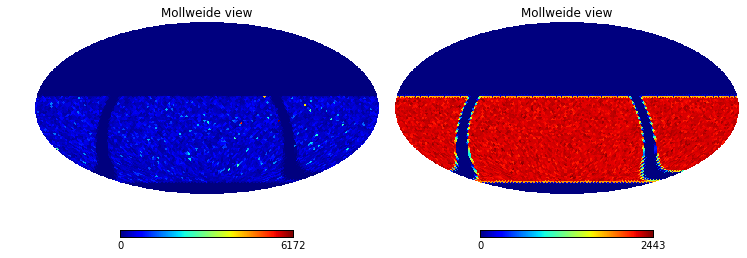

In [9]:
cdata1,ran1=cutDataMakeRandom(data1)

Picked 2053023 from 29293052 objects.
After window:  20530230 -> 6981281


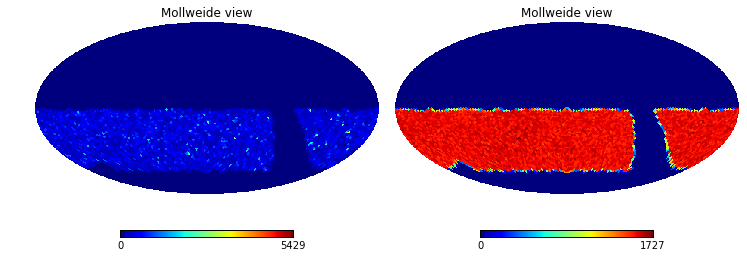

In [10]:
cdata2,ran2=cutDataMakeRandom(data2)

In [11]:
def getCorrelation(cutdata,ran):
    #treecorr catalogs
    cat=tc.Catalog(ra=cutdata['ra'],dec=cutdata['dec'],ra_units='degrees',dec_units='degrees')
    rcat=tc.Catalog(ra=ran['ra'],dec=ran['dec'],ra_units='degrees',dec_units='degrees')
    ## correlators
    dd=tc.NNCorrelation(min_sep=0.001,bin_size=0.1,max_sep=40., sep_units='degrees')
    dd.process(cat)
    dr=tc.NNCorrelation(min_sep=0.001,bin_size=0.1,max_sep=40., sep_units='degrees')
    dr.process(cat,rcat)
    rr=tc.NNCorrelation(min_sep=0.001,bin_size=0.1,max_sep=40., sep_units='degrees')
    rr.process(rcat,rcat)
    xi,xivar=dd.calculateXi(rr,dr)
    logr,meanlogr=dd.logr, dd.meanlogr
    rr=exp(logr)
    return rr,xi,sqrt(xivar)

In [12]:
r1,xi1,xie1=getCorrelation(cdata1,ran1)
r2,xi2,xie2=getCorrelation(cdata2,ran2)

[]

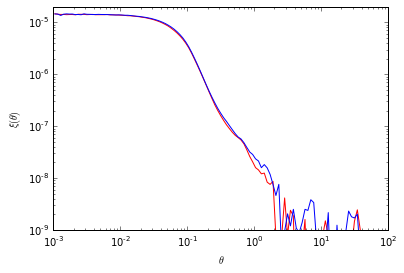

In [13]:
pylab.plot(r1,abs(xi1)/len(cdata1),'r-')
pylab.plot(r2,abs(xi2)/len(cdata2),'b-')
pylab.xlabel('$\\theta$')
pylab.ylabel('$\\xi(\\theta)$')
pylab.ylim(1e-9,2e-5)
pylab.loglog()